## 1. Connecting to PostgreSQL Database and Verifying Data Existence
- We'll use SQLAlchemy to establish a connection to query
- It should connect to the 'social_media_db' we create from the service in the docker-compose.yml
- In the data pipeline section, we created 3 tables: channels, videos, and comments
- To confirm we successfully load all the YouTube social media data, we query counting and print them for verifying Airflow ETL pipeline works.


In [1]:
#source .venv/bin/activate
#jupyter lab

### Define Credentials

In [20]:
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator  # For Chinese → English

# Set professional corporate style
plt.style.use('seaborn-v0_8-whitegrid')

In [21]:
# Define database, which match the 'social_media_db' service in the docker-compose.yml.
# which Docker exposes the service on localhost and "5433:5432" in docker-compose.yml.
user = 'postgres'
password = 'postgres'
host = 'localhost' 
port = 5433         
database = 'social_media_db'

### Create Connection Engine and Test It

In [22]:
# Construct the connection string in PostgreSQL URI format.
conn_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"

# Create the SQLAlchemy engine.
engine = create_engine(conn_string)  

# Test the connection 
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT 1 AS test;"))
        test_value = result.scalar()  # Fetch single value.
    
    if test_value == 1:
        print(f"Connection successful! Connected to {database} on {host}:{port} as {user}.")
        print("Database is ready for queries.")
    else:
        print("Connection test failed unexpectedly.")
        
except Exception as e:
    print(f"Connection error: {e}")
    print("Troubleshooting: Check Docker status (`docker ps`), port forwarding, or credentials.")

Connection successful! Connected to social_media_db on localhost:5433 as postgres.
Database is ready for queries.


### Check 'channels' Table
- The channels table stores YouTube channel metadata which scratch from the ETL process
- You can see features like channel_id, title, subscriber_count
- Insight:
- based on the **"Statistical Summary"**, subscribers and view are **widely dispersed**, but the **total_videos** are similar.

In [5]:
# Define query row count for verification.
count_query = 'SELECT COUNT(*) AS total_rows FROM channels;'

# Also print the first 5 row samples from channels table.
query_channels = 'SELECT * FROM channels;'

# Use SQLAlchemy's native execution
with engine.connect() as conn:
        
    # Execute count query.
    count_result = conn.execute(text(count_query))
    total_channels = count_result.scalar()
    print(f"Total rows: {total_channels}")
    
    # print first 5 rows from channels table
    df_channels = conn.execute(text(query_channels))
    df_channels = pd.DataFrame(df_channels.fetchall(), columns=df_channels.keys())
    print(f"Shape: {df_channels.shape} (rows, columns)")
    print("\nFirst 5 rows:")
    display(df_channels.head(5))  
    
    # stats
    print("\nStatistical Summary:")
    display(df_channels.describe())
    
    print("\nMissing Values per Column:")
    display(df_channels.isnull().sum())

Total rows: 6
Shape: (6, 6) (rows, columns)

First 5 rows:


,channel_id,channel_name,views,total_videos,subscribers,updated_at
0,UC8OVLoXv7B1BdOVV44Dz3ig,Project Umbrella,1318164,236,20100,2025-11-10 06:32:58.995
1,UC7OUGIPx0HIB5HA2OSL-Zhg,MW Insurance Academe 保險為什麼,799045,1857,5400,2025-11-10 06:32:58.995
2,UCD5Lx-3KCYZzCzGF2A60STg,Bowtie Insurance 保泰人壽,52672852,338,85700,2025-11-10 06:32:58.995
3,UCFfbH3zDLa47d4nfotQ349Q,投資最容易,3317417,395,34900,2025-11-10 06:32:58.995
4,UCxQfqaw1i39eBQG1YJDbDkw,UTOPIA HK,623473,326,4170,2025-11-10 06:32:58.995



Statistical Summary:


,views,total_videos,subscribers,updated_at
count,6.000000e+00,6.00000,6.000000,6
mean,1.026350e+07,598.00000,31678.333333,2025-11-10 06:32:58.995000064
min,6.234730e+05,236.00000,4170.000000,2025-11-10 06:32:58.995000
25%,9.288248e+05,329.00000,9075.000000,2025-11-10 06:32:58.995000064
50%,2.084112e+06,366.50000,27500.000000,2025-11-10 06:32:58.995000064
75%,3.200578e+06,425.75000,38575.000000,2025-11-10 06:32:58.995000064
max,5.267285e+07,1857.00000,85700.000000,2025-11-10 06:32:58.995000
std,2.080522e+07,620.50979,30252.266306,NaN



Missing Values per Column:


channel_id      0
channel_name    0
views           0
total_videos    0
subscribers     0
updated_at      0
dtype: int64

### Check 'videos' Table
- The videos table stores all the video created from those YouTube channel, which we scratch from the ETL process
- You can see features like video_id, title, views, likes
- based on the **"Statistical Summary"**, video's views are **widely dispersed**, but the **likes** and **comments** are similar.

In [6]:
# same as above but for videos table
count_query = 'SELECT COUNT(*) AS total_rows FROM videos;'
query_videos = 'SELECT * FROM videos;'

with engine.connect() as conn:
    count_result = conn.execute(text(count_query))
    total_videos = count_result.scalar()
    print(f"Total rows: {total_videos}")

    df_videos = conn.execute(text(query_videos))
    df_videos = pd.DataFrame(df_videos.fetchall(), columns=df_videos.keys())
    #df_videos = df_videos.drop('video_duration', axis=1)
    print(f"Shape: {df_videos.shape} (rows, columns)")
    print("\nFirst rows:")
    display(df_videos.head(1))
    
    # stats
    print("\nStatistical Summary:")
    display(df_videos.describe())
    
    print("\nMissing Values per Column:")
    display(df_videos.isnull().sum())

Total rows: 3302
Shape: (3302, 9) (rows, columns)

First rows:


,video_id,channel_id,channel_name,title,published_at,view_count,like_count,comment_count,duration
0,yyZVVi07oEU,UCD5Lx-3KCYZzCzGF2A60STg,Bowtie Insurance 保泰人壽,日本藥妝店 去水腫 保健食品 = 智商稅 ？｜實測 5秒 水腫測試 皮膚凹陷 可能係 大病 ...,2025-11-06 11:01:05,15354,323,8,1227



Statistical Summary:


,published_at,view_count,like_count,comment_count,duration
count,3302,3.302000e+03,3302.000000,3302.000000,3302.000000
mean,2023-01-15 17:43:04.271653632,1.862354e+04,117.952756,13.155360,679.736826
min,2016-07-04 04:04:18,0.000000e+00,0.000000,0.000000,0.000000
25%,2021-10-24 06:00:03.249999872,6.400000e+01,1.000000,0.000000,180.250000
50%,2023-05-26 10:16:02.500000,3.070000e+02,6.000000,0.000000,523.000000
75%,2024-05-23 21:01:32,2.166000e+03,42.000000,4.000000,836.000000
max,2025-11-10 00:01:01,7.570792e+06,10541.000000,742.000000,13800.000000
std,NaN,1.762063e+05,544.080287,45.850353,804.926360



Missing Values per Column:


video_id         0
channel_id       0
channel_name     0
title            0
published_at     0
view_count       0
like_count       0
comment_count    0
duration         0
dtype: int64

### Check 'comments' Table
- The comments table stores all the comments who made from the audience form those videos, which we scratch from the ETL process
- You can see features like comment_id, text, likes, published_at per videos
- Base on the **vader_score** in the **Statistical Summary**, emotion are similar for each video.

In [7]:
# same as above but for videos table
query_comments = 'SELECT * FROM comments;'
count_query = 'SELECT COUNT(*) AS total_rows FROM comments;'

with engine.connect() as conn:
    count_result = conn.execute(text(count_query))
    total_comments = count_result.scalar()
    print(f"Total rows: {total_comments}")

    df_comments = conn.execute(text(query_comments))
    df_comments = pd.DataFrame(df_comments.fetchall(), columns=df_comments.keys())
    print(f"Shape: {df_comments.shape} (rows, columns)")
    print("\nFirst 5 rows:")
    display(df_comments.head(5))
    
    # stats
    print("\nStatistical Summary:")
    df_comments['vader_score'] = pd.to_numeric(df_comments['vader_score'], errors='coerce')
    df_comments['vader_score'] = df_comments['vader_score'].round(2)
    display(df_comments.describe())
    
    print("\nMissing Values per Column:")
    display(df_comments.isnull().sum())

Total rows: 22136


Shape: (22136, 7) (rows, columns)

First 5 rows:


,comment_id,video_id,channel_id,comment_text,published_at,vader_score,vader_sentiment
0,UgyqofDeh23txPO16ap4AaABAg,yyZVVi07oEU,UCD5Lx-3KCYZzCzGF2A60STg,💓 YouTube 觀眾專屬 雙11感謝祭 優惠碼！【 YT2025 】💓\n💓 由即日至2...,2025-11-06 11:01:49,0.000,neutral
1,UgyJBhT8mPMwFjLUjJR4AaABAg,yyZVVi07oEU,UCD5Lx-3KCYZzCzGF2A60STg,好中意聽Jacky超專業又清晰的講解！,2025-11-08 15:11:44,0.000,neutral
2,UgzTS1JP0rCBBiPBG2t4AaABAg,yyZVVi07oEU,UCD5Lx-3KCYZzCzGF2A60STg,足貼呢個問題應該搵個中醫問😅,2025-11-08 07:22:51,0.000,neutral
3,UgyM922XbPNRU6v-z2N4AaABAg,yyZVVi07oEU,UCD5Lx-3KCYZzCzGF2A60STg,解釋得好清楚👍🏻,2025-11-07 18:28:11,0.000,neutral
4,Ugww2Tj1eW6kH94ByRR4AaABAg,yyZVVi07oEU,UCD5Lx-3KCYZzCzGF2A60STg,感恩 人不能透視內臟 但可以目測\n五官四肢的水腫程度 了解病癥,2025-11-07 09:52:12,0.000,neutral



Statistical Summary:


,published_at,vader_score
count,22136,22136.000000
mean,2024-09-08 03:01:44.970184448,0.033155
min,2016-07-04 04:32:48,-0.860000
25%,2024-03-19 03:13:07,0.000000
50%,2024-12-22 16:58:33.500000,0.000000
75%,2025-07-10 15:46:35.750000128,0.000000
max,2025-11-10 06:28:13,0.990000
std,NaN,0.148042



Missing Values per Column:


comment_id         0
video_id           0
channel_id         0
comment_text       0
published_at       0
vader_score        0
vader_sentiment    0
dtype: int64

## 2. Analyzing Bowtie's YouTube Content Strategy Evolution

### 2a. How many videos do Bowtie made in these year?
- on avg, they make around 6 video a month (Monthly Production Rates)
- in 2024-03, they make the most video (Maximum Output Capacity)

In [8]:
# Monthly video counts for Bowtie
query = """
SELECT
    TO_CHAR(published_at, 'YYYY-MM') AS publication_month,
    COUNT(*) AS video_count
FROM videos
WHERE channel_id = 'UCD5Lx-3KCYZzCzGF2A60STg'
GROUP BY TO_CHAR(published_at, 'YYYY-MM')
ORDER BY publication_month ASC;
"""

# run it
with engine.connect() as conn:
    # Execute main query
    result = conn.execute(text(query))
    # Build DF
    df_time_series = pd.DataFrame(result.fetchall(), columns=result.keys())

print("Monthly Video Production Summary:")
display(df_time_series.head(5))

print(f"Total months with data: {len(df_time_series)}")
print(f"Average videos/month: {df_time_series['video_count'].mean():.1f}")
df_time_series['publication_month'] = pd.to_datetime(df_time_series['publication_month'].astype(str) + '-01')
peak_idx = df_time_series['video_count'].idxmax()  # Get the index of max video_count
print(f"Peak month: {df_time_series.loc[peak_idx, 'publication_month'].strftime('%Y-%m')} ({df_time_series['video_count'].max()} videos)")

Monthly Video Production Summary:


,publication_month,video_count
0,2019-04,2
1,2019-05,2
2,2019-06,1
3,2019-07,2
4,2020-02,3


Total months with data: 54
Average videos/month: 6.3
Peak month: 2024-03 (23 videos)


### [Insight in Pattern Recognition] Bowtie have shift their marketing strategies a few times

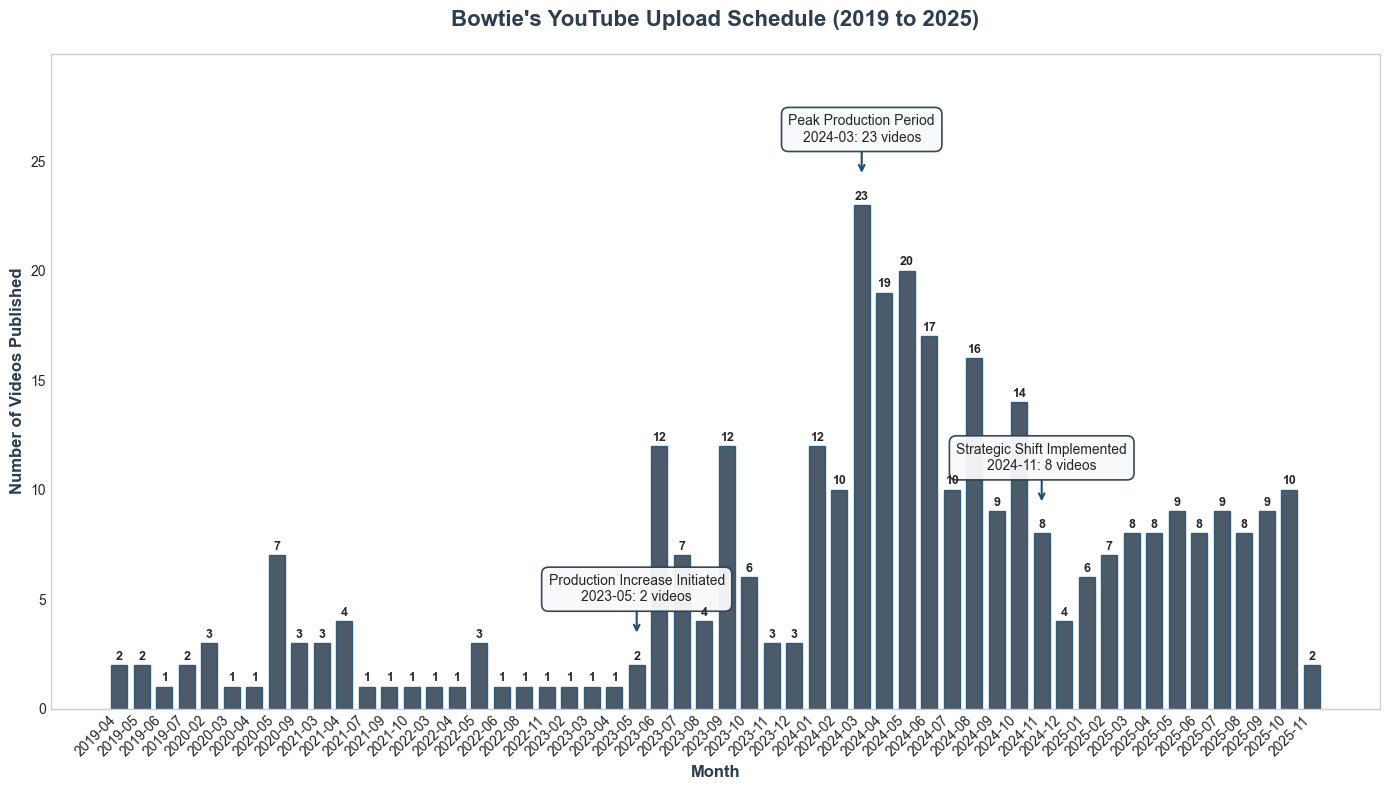

In [9]:
# Create figure with professional styling
fig1, ax1 = plt.subplots(figsize=(14, 8))

# Prep and plot
df_time_series_plot = df_time_series.copy()
df_time_series_plot['publication_month_str'] = df_time_series_plot['publication_month'].dt.strftime('%Y-%m')

# Create the bar plot
bars = ax1.bar(
    df_time_series_plot['publication_month_str'],
    df_time_series_plot['video_count'],
    color='#2C3E50',  # Professional blue
    alpha=0.85,
    edgecolor='#1B4F72',  # Dark blue edge
    linewidth=1.0,
    width=0.7
)

# Professional annotation style parameters
ANNOTATION_STYLE = {
    'fontsize': 10,
    'ha': 'center',
    'va': 'center',
    'bbox': dict(boxstyle="round,pad=0.5", fc="#F8F9FA", ec="#2C3E50", lw=1.2, alpha=0.95),
    'arrowprops': dict(arrowstyle="->", color='#1B4F72', lw=1.5, shrinkA=0, shrinkB=5)
}

# Define a small upward offset for arrow start
arrow_offset = max(df_time_series_plot['video_count']) * 0.05

# Find the peak for annotation
peak_month_str = df_time_series_plot.loc[df_time_series_plot['video_count'].idxmax(), 'publication_month_str']
peak_value = df_time_series_plot['video_count'].max()
peak_idx = list(df_time_series_plot['publication_month_str']).index(peak_month_str)

# Peak annotation
ax1.annotate(
    f"Peak Production Period\n{peak_month_str}: {peak_value} videos",
    xy=(peak_idx, peak_value + arrow_offset),
    xytext=(peak_idx, peak_value + (peak_value * 0.15)),
    **ANNOTATION_STYLE
)

# Annotation for 2023-05: Start increase video production
if '2023-05' in df_time_series_plot['publication_month_str'].values:
    may_2023_idx = list(df_time_series_plot['publication_month_str']).index('2023-05')
    may_2023_count = df_time_series_plot.loc[may_2023_idx, 'video_count']
    
    ax1.annotate(
        f"Production Increase Initiated\n2023-05: {may_2023_count} videos",
        xy=(may_2023_idx, may_2023_count + arrow_offset),
        xytext=(may_2023_idx, may_2023_count + (peak_value * 0.15)),
        **ANNOTATION_STYLE
    )

# Annotation for 2024-11: Change strategy in video production
if '2024-11' in df_time_series_plot['publication_month_str'].values:
    nov_2024_idx = list(df_time_series_plot['publication_month_str']).index('2024-11')
    nov_2024_count = df_time_series_plot.loc[nov_2024_idx, 'video_count']
    
    ax1.annotate(
        f"Strategic Shift Implemented\n2024-11: {nov_2024_count} videos",
        xy=(nov_2024_idx, nov_2024_count + arrow_offset),
        xytext=(nov_2024_idx, nov_2024_count + (peak_value * 0.15)),
        **ANNOTATION_STYLE
    )

# Title and labels
ax1.set_title("Bowtie's YouTube Upload Schedule (2019 to 2025)", 
              fontsize=16, pad=20, fontweight='bold', color='#2C3E50')
ax1.set_xlabel("Month", fontsize=12, fontweight='bold', color='#2C3E50')
ax1.set_ylabel("Number of Videos Published", fontsize=12, fontweight='bold', color='#2C3E50')

# X-axis label rotation
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Adjust y-axis limit to accommodate annotations
max_count = df_time_series_plot['video_count'].max()
ax1.set_ylim(0, max_count * 1.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.grid(False)  # Disable grid lines
plt.tight_layout()
plt.savefig('visualization/Bowtie YouTube Upload Schedule.png', dpi=300, bbox_inches='tight') 
plt.show()

## What do Bowtie's audience actually excited about?

### [Correlation Testing] More videos mean more engagement?
More videos have negative effect to the engagement on bowties's channel
- When video count increases, Avg Views DECREASES slightly (r = -0.017)
- When video count increases, Avg Likes DECREASES moderately (r = -0.362)
- When video count increases, Avg Video Comments DECREASES moderately (r = -0.432)When video count increases, Avg Comments Per Video DECREASES moderately (r = -0.416)

In [10]:
query = """
SELECT
  TO_CHAR(v.published_at, 'YYYY-MM') AS month_year,
  COUNT(DISTINCT v.video_id) AS video_count,
  AVG(v.view_count) AS avg_views,
  AVG(v.like_count) AS avg_likes,
  AVG(v.comment_count) AS avg_video_comments, -- From videos table
  COALESCE(AVG(c.comment_count), 0) AS avg_comments_per_video, -- Handle no comments
  COALESCE(AVG(c.avg_vader_score), 0) AS avg_vader_score -- Handle no scores
FROM videos v
LEFT JOIN (
  SELECT
    video_id,
    COUNT(*) AS comment_count,
    COALESCE(AVG(vader_score), 0) AS avg_vader_score
  FROM comments
  GROUP BY video_id
) c ON v.video_id = c.video_id
WHERE v.channel_id = 'UCD5Lx-3KCYZzCzGF2A60STg'
  AND v.published_at >= '2024-01-01'::date
  AND v.published_at <= '2025-10-31'::date
GROUP BY TO_CHAR(v.published_at, 'YYYY-MM')
ORDER BY month_year ASC;
"""

with engine.connect() as conn:
    # Execute
    result = conn.execute(text(query))
  
    # Build DF with correct columns
    df_monthly = pd.DataFrame(result.fetchall(), columns=result.keys())

# Fix dtypes: convert numeric columns to float/int
numeric_cols = ['video_count', 'avg_views', 'avg_likes', 'avg_video_comments', 'avg_comments_per_video', 'avg_vader_score']
for col in numeric_cols:
    if col in df_monthly.columns:
        df_monthly[col] = pd.to_numeric(df_monthly[col], errors='coerce')

# Convert month_year to datetime and set as index
df_monthly['month_year'] = pd.to_datetime(df_monthly['month_year'])
df = df_monthly.set_index('month_year').sort_index()

#print("Bowtie Monthly Engagement Breakdown (2024):")
display(df.round(2))  

,video_count,avg_views,avg_likes,avg_video_comments,avg_comments_per_video,avg_vader_score
month_year,,,,,,
2024-01-01,12,18474.00,66.25,3.67,2.58,0.02
2024-02-01,10,51307.40,67.20,4.10,3.57,0.00
2024-03-01,23,205273.04,998.52,11.83,14.71,0.02
2024-04-01,19,16174.42,127.05,6.42,4.59,0.00
2024-05-01,20,9500.30,29.95,4.45,4.33,0.00
2024-06-01,17,4331.12,51.12,6.41,5.91,0.00
2024-07-01,10,1226.50,19.30,1.80,2.80,0.10
2024-08-01,16,13525.56,196.56,20.38,19.33,0.01
2024-09-01,9,119082.00,732.22,57.67,47.14,0.01


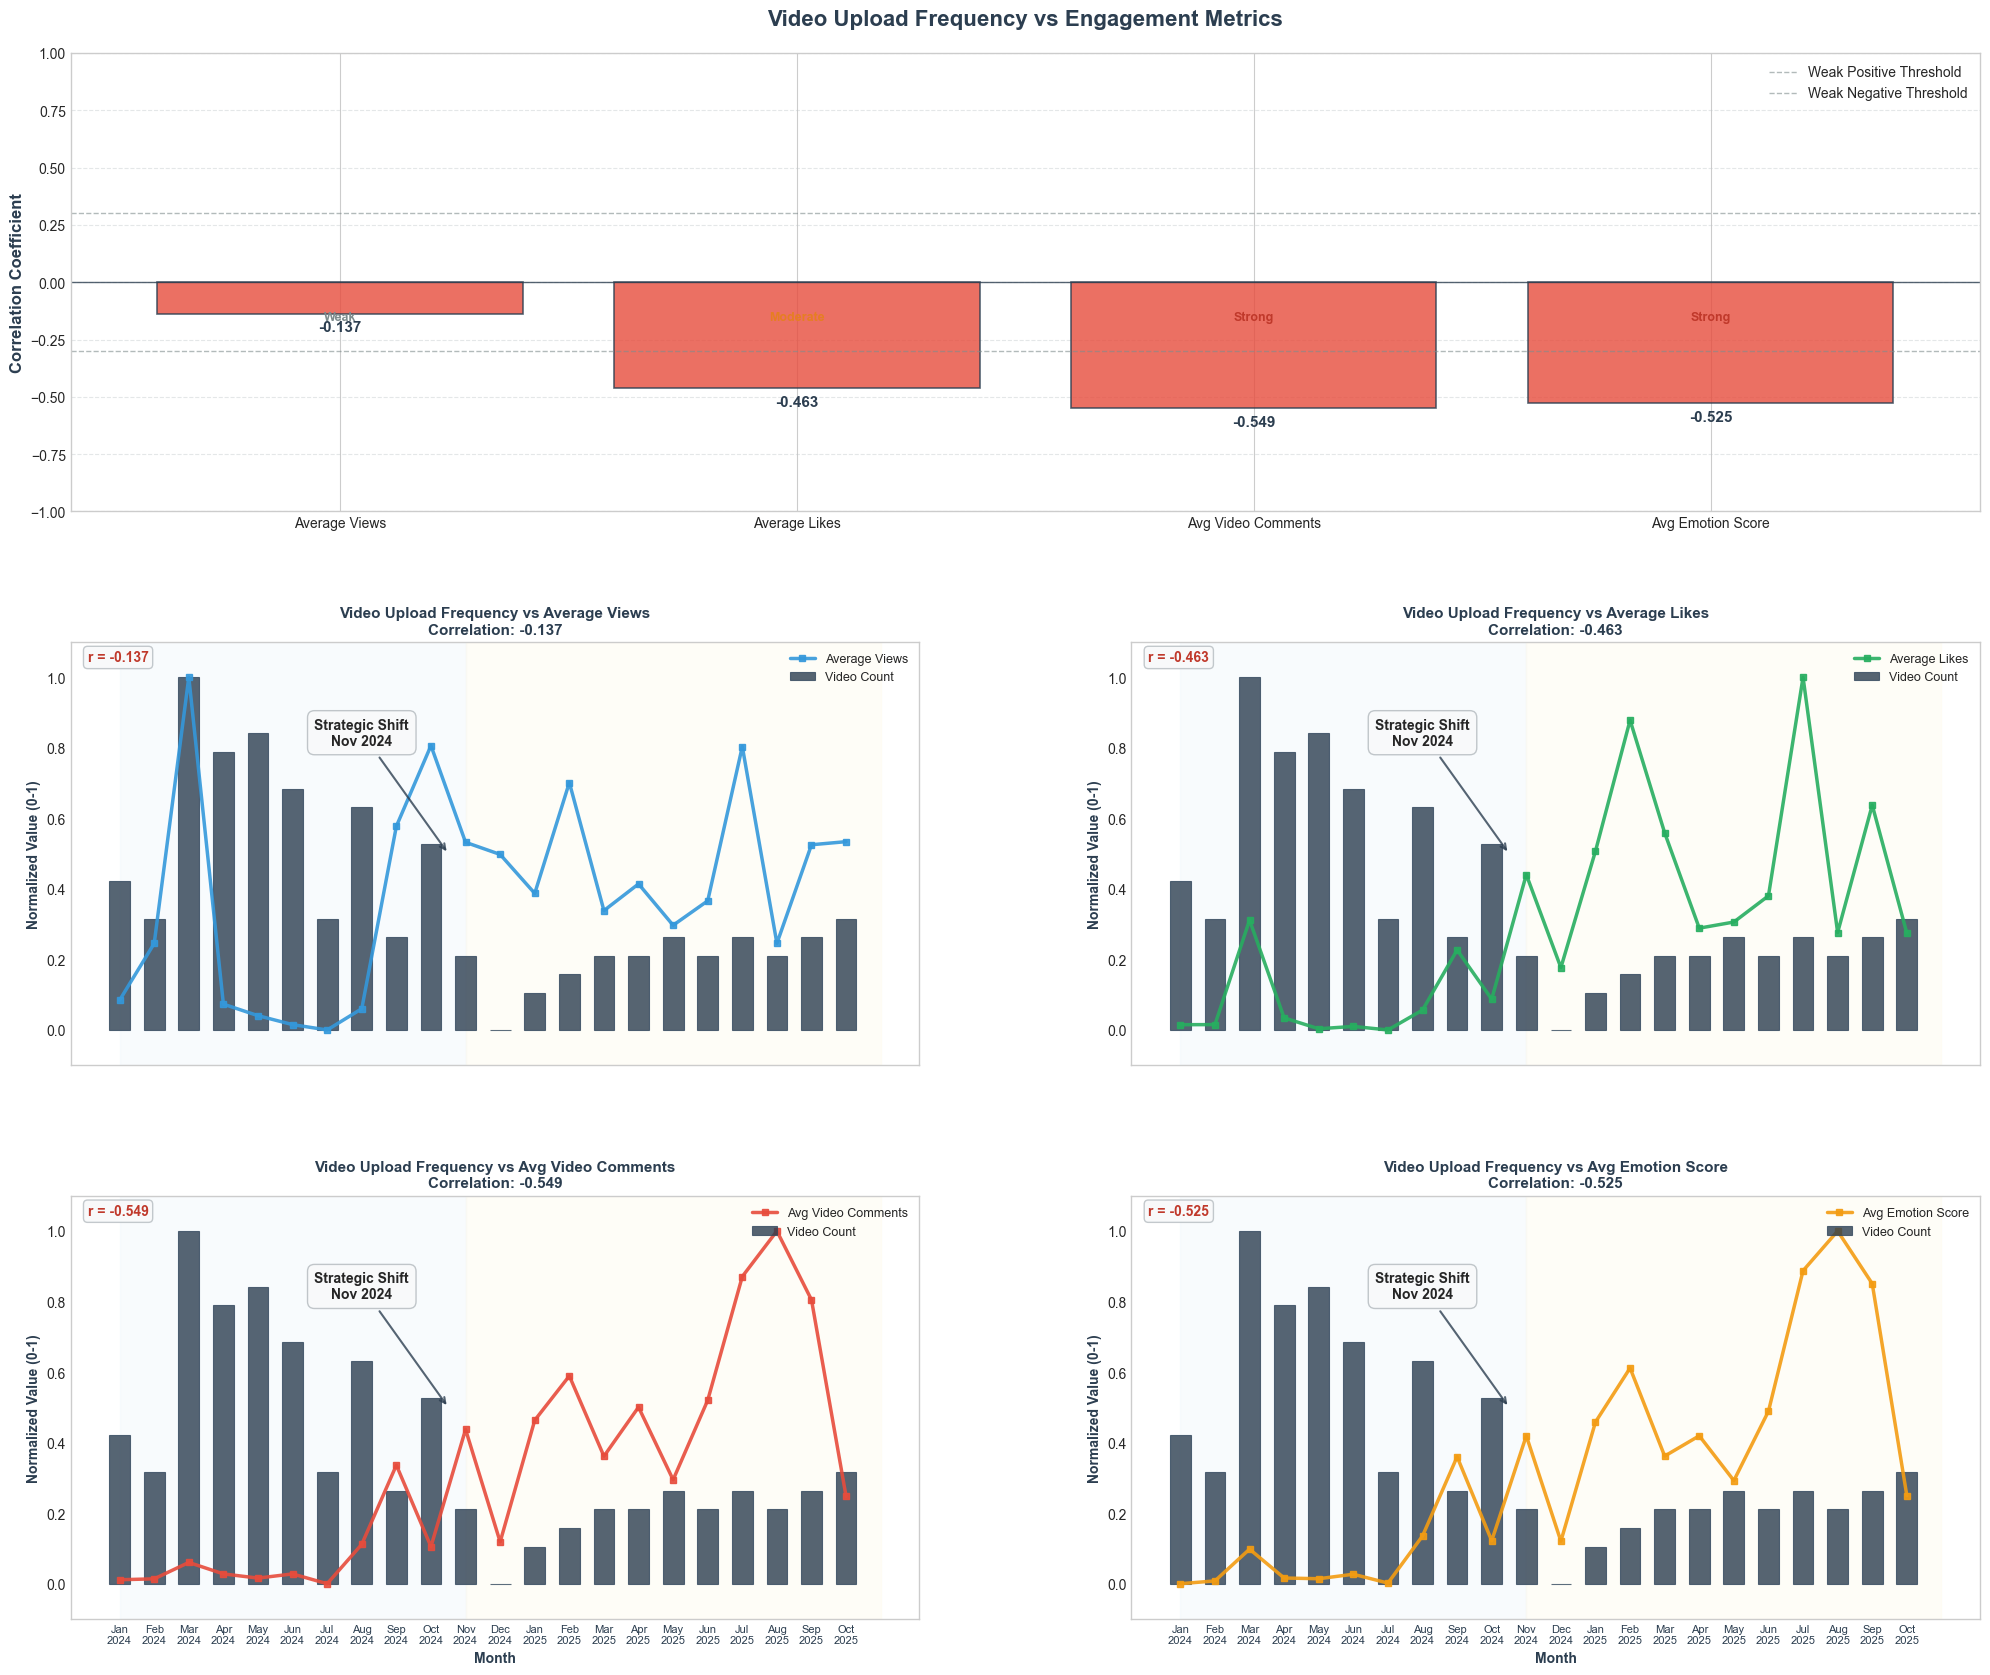


ENGAGEMENT CORRELATION SUMMARY:
• Views: Weak negative correlation (r = -0.137)
• Likes: Moderate negative correlation (r = -0.463)
• Video Comments: Strong negative correlation (r = -0.549)
• Comments Per Video: Strong negative correlation (r = -0.525)


In [11]:
fig2 = plt.figure(figsize=(20, 18))  # Slightly reduced height
gs = GridSpec(3, 2, figure=fig2, height_ratios=[1.3, 1.2, 1.2])

# PART 1: CORRELATION ANALYSIS
ax2 = fig2.add_subplot(gs[0, :])
engagement_metrics = ['avg_views', 'avg_likes', 'avg_video_comments', 'avg_comments_per_video']
correlations = {}
for metric in engagement_metrics:
    corr = df_monthly['video_count'].corr(df_monthly[metric])
    correlations[metric] = corr

# Plot correlations with professional color scheme
metrics_display = ['Average Views', 'Average Likes', 'Avg Video Comments', 'Avg Emotion Score']
corr_values = [correlations[metric] for metric in engagement_metrics]
colors = ['#E74C3C' if val < 0 else '#27AE60' if val > 0.1 else '#F39C12' for val in corr_values]  # Red, green, orange
bars = ax2.bar(metrics_display, corr_values, color=colors, alpha=0.8, edgecolor='#2C3E50', linewidth=1.2)

# Professional title and label styling
ax2.set_title('Video Upload Frequency vs Engagement Metrics', 
              fontsize=16, fontweight='bold', pad=20, color='#2C3E50')
ax2.set_ylabel('Correlation Coefficient', fontsize=12, fontweight='bold', color='#2C3E50')
ax2.set_ylim(-1, 1)
ax2.axhline(y=0, color='#2C3E50', linestyle='-', alpha=0.8, linewidth=1)
ax2.axhline(y=0.3, color='#7F8C8D', linestyle='--', alpha=0.6, linewidth=1.0, label='Weak Positive Threshold')
ax2.axhline(y=-0.3, color='#7F8C8D', linestyle='--', alpha=0.6, linewidth=1.0, label='Weak Negative Threshold')
ax2.grid(axis='y', alpha=0.4, linestyle='--', color='#BDC3C7')

# Add value labels and significance indicators
for bar, val, metric in zip(bars, corr_values, engagement_metrics):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    y_pos = height + 0.02 if height >= 0 else height - 0.03
    ax2.text(bar.get_x() + bar.get_width()/2, y_pos, f'{val:.3f}', 
             ha='center', va=va, fontweight='bold', fontsize=11, color='#2C3E50')
    
    # Add significance marker
    if abs(val) > 0.5:
        significance = "Strong"
        color = "#C0392B" if val < 0 else "#229954"
    elif abs(val) > 0.3:
        significance = "Moderate"
        color = "#E67E22" if val < 0 else "#17A589"
    else:
        significance = "Weak"
        color = "#7F8C8D"
    
    ax2.text(bar.get_x() + bar.get_width()/2, -0.15, significance, 
             ha='center', va='center', fontweight='bold', color=color, fontsize=9)

# Professional insight annotation
insight_text = "ANALYSIS: Negative correlations indicate potential trade-off between video quantity and engagement quality.\nHigher production frequency may dilute per-video audience interaction."
ax2.text(0.02, -0.85, insight_text, transform=ax2.transAxes, fontsize=11,
         style='italic', color='#2C3E50', 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="#F8F9FA", alpha=0.9, edgecolor='#BDC3C7'))
ax2.legend(loc='upper right', framealpha=0.9)

# PART 2: NORMALIZED TIME SERIES COMPARISONS
def normalize_column(series):
    min_val = series.min()
    max_val = series.max()
    if max_val > min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return series * 0

# Prepare comparison data
df_comparison = df_monthly.copy()
df_comparison['month_year_dt'] = pd.to_datetime(df_comparison['month_year'].astype(str) + '-01')
df_comparison = df_comparison.set_index('month_year_dt')
df_comparison['video_count_norm'] = normalize_column(df_comparison['video_count'])
df_comparison['avg_views_norm'] = normalize_column(df_comparison['avg_views'])
df_comparison['avg_likes_norm'] = normalize_column(df_comparison['avg_likes'])
df_comparison['avg_video_comments_norm'] = normalize_column(df_comparison['avg_video_comments'])
df_comparison['avg_comments_per_video_norm'] = normalize_column(df_comparison['avg_comments_per_video'])

# Find split position for background shading
split_date = pd.to_datetime('2024-11-01')
after_split = df_comparison[df_comparison.index >= split_date]
if not after_split.empty:
    split_idx = df_comparison.index.get_loc(after_split.index[0])
else:
    split_idx = len(df_comparison)
split_pos = split_idx

# Create subplots for comparisons
axes = [
    fig2.add_subplot(gs[1, 0]),
    fig2.add_subplot(gs[1, 1]),
    fig2.add_subplot(gs[2, 0]),
    fig2.add_subplot(gs[2, 1])
]

# Configuration for each subplot - professional color scheme
plot_configs = [
    ('avg_views_norm', 'Average Views', '#3498DB', correlations['avg_views']),  # Blue
    ('avg_likes_norm', 'Average Likes', '#27AE60', correlations['avg_likes']),  # Green
    ('avg_video_comments_norm', 'Avg Video Comments', '#E74C3C', correlations['avg_video_comments']),  # Red
    ('avg_comments_per_video_norm', 'Avg Emotion Score', '#F39C12', correlations['avg_comments_per_video'])  # Orange
]

# Plot each comparison
x_pos = np.arange(len(df_comparison))
for idx, (metric_col, metric_name, color, corr) in enumerate(plot_configs):
    ax = axes[idx]
    
    # Add subtle background shading
    ax.axvspan(0, split_pos, color='#EBF5FB', alpha=0.3)  # Very light blue
    ax.axvspan(split_pos, len(df_comparison), color='#FEF9E7', alpha=0.3)  # Very light yellow
    
    # Plot video count as bars
    bars = ax.bar(x_pos, df_comparison['video_count_norm'], 
                  label='Video Count', color='#2C3E50', alpha=0.8, width=0.6, 
                  edgecolor='#34495E', linewidth=0.8)
    
    # Plot the metric as line
    ax.plot(x_pos, df_comparison[metric_col], label=metric_name, 
            color=color, linewidth=2.5, marker='s', markersize=5, alpha=0.9)
    
    # Professional annotation
    if 0 < split_pos < len(df_comparison):
        annotation_text = "Strategic Shift\nNov 2024"
        ax.annotate(annotation_text, 
                    xy=(split_pos - 0.5, 0.5),
                    xytext=(split_pos - 3, 0.8),
                    arrowprops=dict(arrowstyle='->', color='#2C3E50', lw=1.5, alpha=0.8),
                    fontsize=10, ha='center', va='bottom', fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="#F8F9FA", alpha=0.95, edgecolor='#BDC3C7'),
                    transform=ax.transData)
    
    # Professional subplot styling
    ax.set_title(f'Video Upload Frequency vs {metric_name}\nCorrelation: {corr:.3f}', 
                 fontweight='bold', fontsize=11, color='#2C3E50')
    ax.set_ylabel('Normalized Value (0-1)', fontsize=10, fontweight='bold', color='#2C3E50')
    ax.legend(fontsize=9, loc='upper right', framealpha=0.9)
    ax.grid(False)  # Disable grid lines
    ax.set_ylim(-0.1, 1.1)
    
    # X-axis formatting
    if idx >= 2:
        ax.set_xticks(x_pos)
        ax.set_xticklabels([month.strftime('%b\n%Y') for month in df_comparison.index],
                          fontsize=8, rotation=0, color='#2C3E50')
        ax.set_xlabel('Month', fontsize=10, fontweight='bold', color='#2C3E50')
    else:
        ax.set_xticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False)
    
    # Professional correlation indicator
    correlation_color = '#C0392B' if corr < 0 else '#27AE60' if corr > 0.3 else '#F39C12'
    ax.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', color=correlation_color,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="#F8F9FA", alpha=0.9, edgecolor='#BDC3C7'))

# Final professional touches
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.25, bottom=0.08)
plt.grid(False)  # Disable grid lines
plt.savefig('visualization/Video Upload Frequency vs Engagement Metrics.png', dpi=300, bbox_inches='tight') 
plt.show()

# =============================================================================
# ADDITIONAL INSIGHTS SUMMARY
# =============================================================================

print("\nENGAGEMENT CORRELATION SUMMARY:")
for metric, corr in correlations.items():
    metric_name = metric.replace('avg_', '').replace('_', ' ').title()
    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    direction = "negative" if corr < 0 else "positive"
    print(f"• {metric_name}: {strength} {direction} correlation (r = {corr:.3f})")

### 2b. [Correlation Testing] Longer videos mean more engagement?

In [27]:
query = """
SELECT 
    AVG(v.duration) AS avg_duration_seconds,
    AVG(v.duration)/60 AS avg_duration_minutes
FROM videos v
WHERE v.channel_id = 'UCD5Lx-3KCYZzCzGF2A60STg'
;

"""

with engine.connect() as conn:
    # Execute
    result = conn.execute(text(query))
  
    # Build DF with correct columns
    df_monthly = pd.DataFrame(result.fetchall(), columns=result.keys())

df = df_monthly.copy()
display(df.round(2))

,avg_duration_seconds,avg_duration_minutes
0,559.9526627218934911,9.3325443786982249


duration_category
Long     76
Short    24
Name: count, dtype: int64


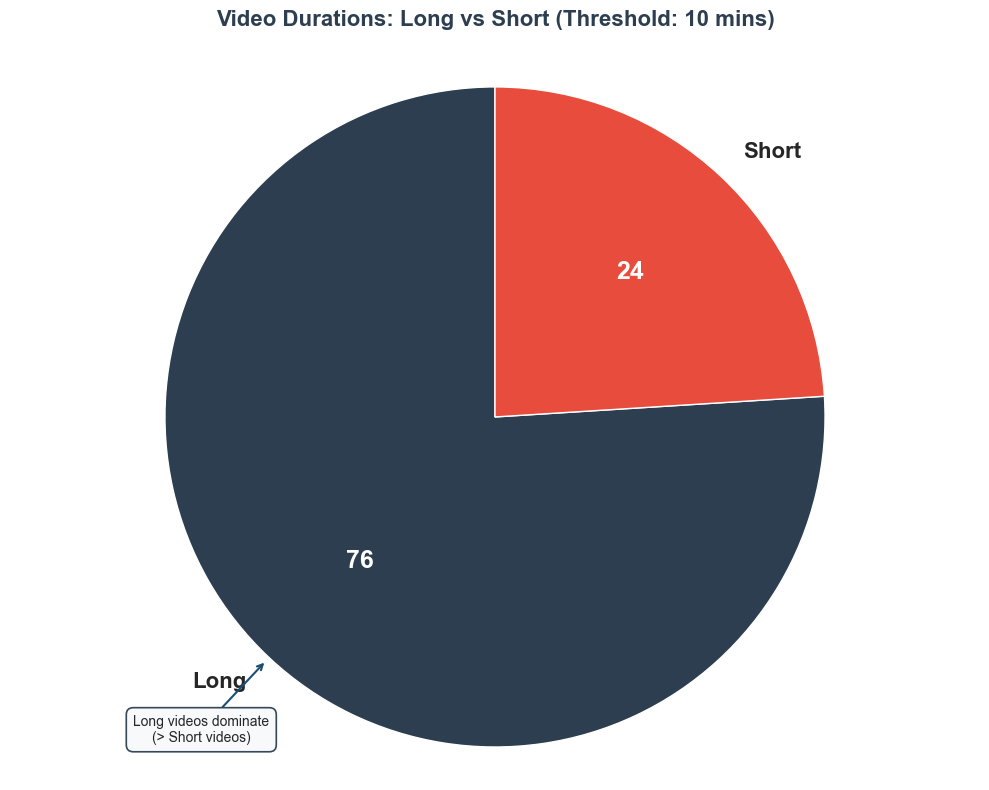

In [32]:
# Query (using dummy data)
data = {'duration': [601] * 76 + [300] * 24}  # Dummy durations in seconds
df_videos = pd.DataFrame(data)

# Categorize durations (threshold: 10 mins = 600 seconds)
df_videos['duration_category'] = df_videos['duration'].apply(lambda x: 'Long' if x > 600 else 'Short')

# Count the categories
counts = df_videos['duration_category'].value_counts()

# Custom autopct function to show absolute counts
def make_autopct(counts):
    def my_autopct(pct):
        return f'{int(round(pct / 100. * sum(counts)))}'
    return my_autopct

# Create figure with professional styling
fig, ax = plt.subplots(figsize=(10, 8))

# Plot pie chart with custom colors
colors = ['#2C3E50', '#E74C3C']  # Professional blue for Long, red for Short
wedges, texts, autotexts = ax.pie(counts.values, labels=counts.index, colors=colors,
                                  autopct=make_autopct(counts.values), startangle=90)

# Set the color and larger size of the numbers inside the pie to white
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(18)  # Increased size for numbers (76, 24)

# Set larger size for labels 'Long' and 'Short'
for text in texts:
    text.set_fontsize(16)  # Increased size for labels
    text.set_fontweight('bold')

# Professional annotation style parameters
ANNOTATION_STYLE = {
    'fontsize': 10,
    'ha': 'center',
    'va': 'center',
    'bbox': dict(boxstyle="round,pad=0.5", fc="#F8F9FA", ec="#2C3E50", lw=1.2, alpha=0.95),
    'arrowprops': dict(arrowstyle="->", color='#1B4F72', lw=1.5, shrinkA=0, shrinkB=5)
}

# Add annotation outside the pie, pointing to the Long slice
# Assuming 'Long' is the first category (index 0)
long_wedge = wedges[0]
angle = (long_wedge.theta1 + long_wedge.theta2) / 2
rad = np.radians(angle)
xy = (np.cos(rad), np.sin(rad))  # Position on the pie edge
xytext = (1.3 * xy[0], 1.3 * xy[1])  # Outside position

ax.annotate('Long videos dominate\n(> Short videos)', xy=xy, xytext=xytext,
            **ANNOTATION_STYLE)

# Title with professional styling
ax.set_title('Video Durations: Long vs Short (Threshold: 10 mins)', 
             fontsize=16, pad=20, fontweight='bold', color='#2C3E50')
ax.axis('equal')  # Equal aspect ratio ensures pie is circular

plt.grid(False)  # Disable grid lines
plt.tight_layout()
plt.savefig('visualization/duration_pie_chart.png', dpi=300, bbox_inches='tight')

# Optional: Print counts for reference
print(counts)

plt.show()

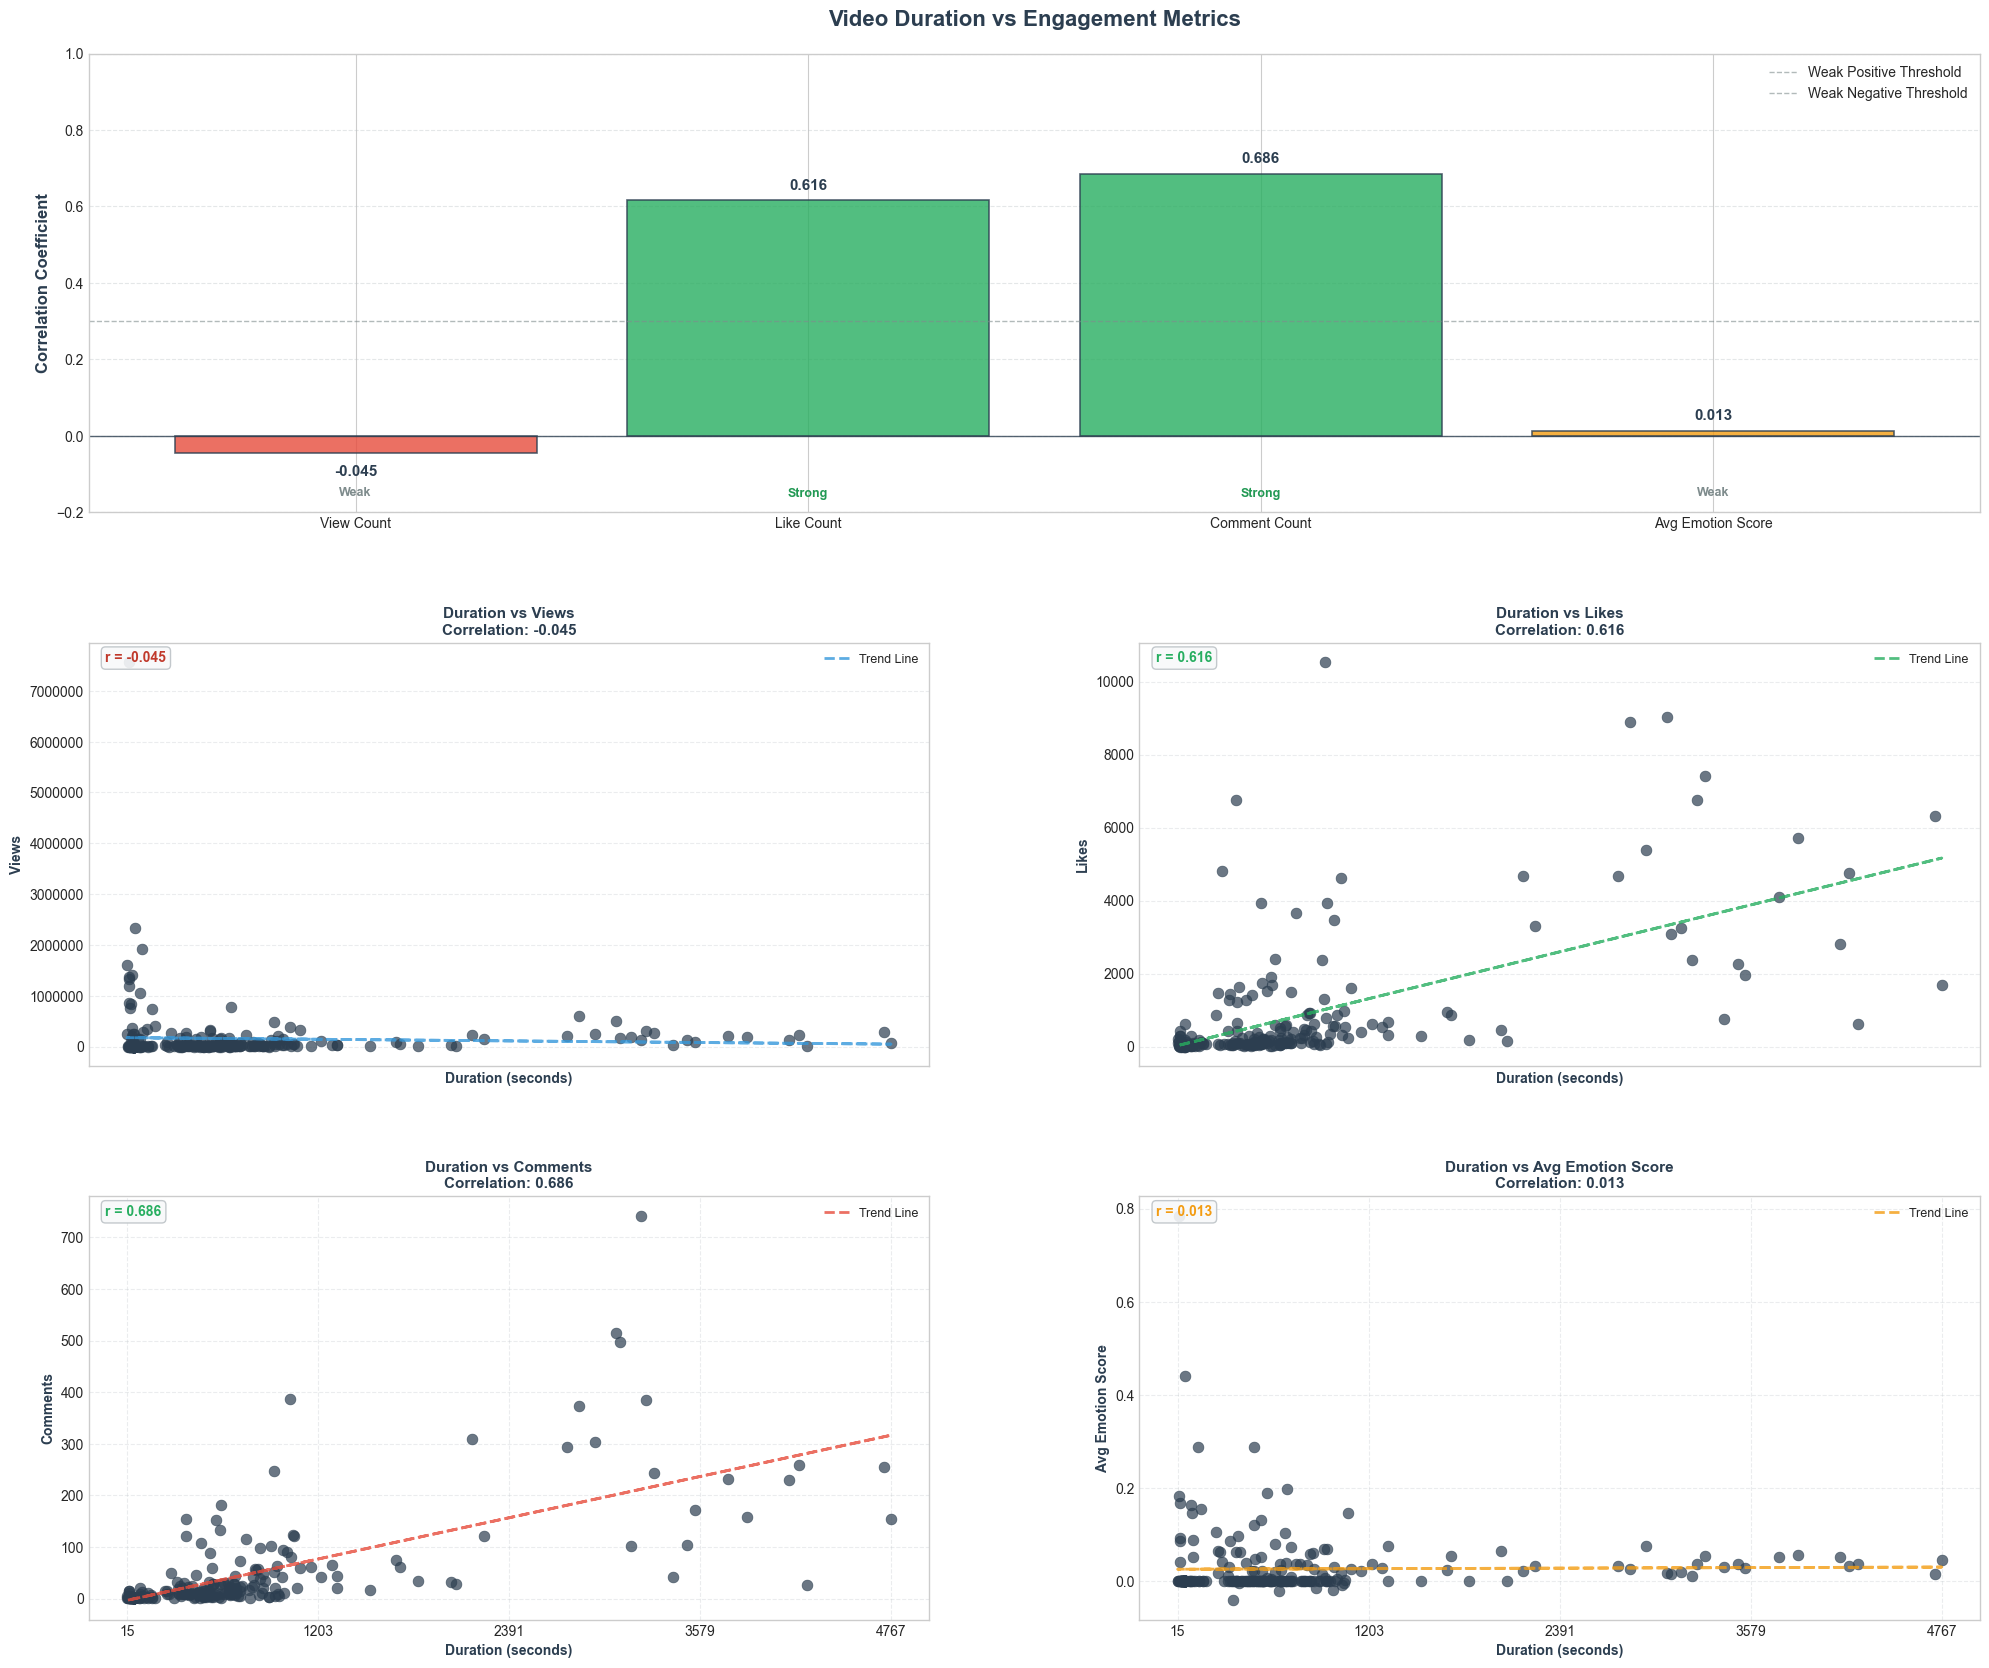


ENGAGEMENT CORRELATION SUMMARY:
• View: Weak negative correlation (r = -0.045)
• Like: Strong positive correlation (r = 0.616)
• Comment: Strong positive correlation (r = 0.686)
• Vader_Score: Weak positive correlation (r = 0.013)


In [13]:
# Query
query_videos = """
SELECT * 
FROM videos v
WHERE v.channel_id = 'UCD5Lx-3KCYZzCzGF2A60STg'
  AND v.published_at >= '2020-01-01'::date
  AND v.published_at <= '2025-10-31'::date
;
"""

try:
    with engine.connect() as conn:
        result_videos = conn.execute(text(query_videos))
        df_videos = pd.DataFrame(result_videos.fetchall(), columns=result_videos.keys())
    #print(f"Loaded {len(df_videos)} videos.")
except SQLAlchemyError as e:
    print(f"SQL Error for videos: {e}")
    df_videos = pd.DataFrame()  # Empty if error

if len(df_videos) == 0:
    print("No video data loaded. Check your query/channel_id.")
else:
    # For emotion score: Query avg vader_score per video (join comments)
    query_sentiment = """
    SELECT 
        v.video_id,
        v.duration,
        v.published_at,
        AVG(c.vader_score) AS avg_vader_score
    FROM videos v
    LEFT JOIN comments c ON v.video_id = c.video_id
    WHERE v.channel_id = 'UCD5Lx-3KCYZzCzGF2A60STg'
      AND v.published_at >= '2020-01-01'::date
      AND v.published_at <= '2025-10-31'::date
    GROUP BY v.video_id, v.duration, v.published_at
    ORDER BY v.published_at DESC;
    """
    
    try:
        with engine.connect() as conn:
            result_sentiment = conn.execute(text(query_sentiment))
            df_sentiment = pd.DataFrame(result_sentiment.fetchall(), columns=result_sentiment.keys())
        #print(f"Loaded sentiment data for {len(df_sentiment)} videos.")
    except SQLAlchemyError as e:
        print(f"SQL Error for sentiment: {e}")
        df_sentiment = pd.DataFrame()
    
    # Merge sentiment into videos df (handle missing sentiment as NaN)
    df = df_videos.merge(df_sentiment[['video_id', 'avg_vader_score']], on='video_id', how='left')
    
    # FIX: Convert Decimal columns to float to avoid TypeError in pearsonr
    numeric_cols = ['view_count', 'like_count', 'comment_count', 'duration', 'avg_vader_score']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Converts Decimal/int to float, NaN on fail
    
    # Clean data: Drop rows with NaN in key columns
    df_clean = df.dropna(subset=['duration', 'view_count', 'like_count', 'comment_count', 'avg_vader_score'])
    
    if len(df_clean) < 2:
        print("Insufficient clean data for plotting (need >=2 rows).")
    else:
        # Calculate correlations for bar plot
        metrics = ['view_count', 'like_count', 'comment_count', 'avg_vader_score']
        correlations = {}
        for metric in metrics:
            corr_coef, _ = pearsonr(df_clean['duration'], df_clean[metric])
            correlations[metric] = corr_coef
        
        # Set style for plots
        sns.set_style("whitegrid")
        
        # Create combined figure with GridSpec: Bar on top (taller), 2x2 scatters below (equal heights)
        fig = plt.figure(figsize=(20, 18))  # Larger size to match second code
        gs = GridSpec(3, 2, figure=fig, height_ratios=[1.3, 1.2, 1.2])  # Uneven heights for bar emphasis
        
        # PART 1: CORRELATION ANALYSIS (Bar Plot on Top)
        ax_bar = fig.add_subplot(gs[0, :])  # Full width top row
        metrics_display = ['View Count', 'Like Count', 'Comment Count', 'Avg Emotion Score']
        corr_values = [correlations[metric] for metric in metrics]
        colors = ['#E74C3C' if val < 0 else '#27AE60' if val > 0.1 else '#F39C12' for val in corr_values]  # Red, green, orange
        bars = ax_bar.bar(metrics_display, corr_values, color=colors, alpha=0.8, edgecolor='#2C3E50', linewidth=1.2)
        
        # Professional title and label styling
        ax_bar.set_title('Video Duration vs Engagement Metrics', 
                         fontsize=16, fontweight='bold', pad=20, color='#2C3E50')
        ax_bar.set_ylabel('Correlation Coefficient', fontsize=12, fontweight='bold', color='#2C3E50')
        ax_bar.set_ylim(-0.2, 1.0)
        ax_bar.axhline(y=0, color='#2C3E50', linestyle='-', alpha=0.8, linewidth=1)
        ax_bar.axhline(y=0.3, color='#7F8C8D', linestyle='--', alpha=0.6, linewidth=1.0, label='Weak Positive Threshold')
        ax_bar.axhline(y=-0.3, color='#7F8C8D', linestyle='--', alpha=0.6, linewidth=1.0, label='Weak Negative Threshold')
        ax_bar.grid(axis='y', alpha=0.4, linestyle='--', color='#BDC3C7')
        
        # Add value labels and significance indicators
        for bar, val, metric in zip(bars, corr_values, metrics):
            height = bar.get_height()
            va = 'bottom' if height >= 0 else 'top'
            y_pos = height + 0.02 if height >= 0 else height - 0.03
            ax_bar.text(bar.get_x() + bar.get_width()/2, y_pos, f'{val:.3f}', 
                        ha='center', va=va, fontweight='bold', fontsize=11, color='#2C3E50')
            
            # Add significance marker
            if abs(val) > 0.5:
                significance = "Strong"
                color_sig = "#C0392B" if val < 0 else "#229954"
            elif abs(val) > 0.3:
                significance = "Moderate"
                color_sig = "#E67E22" if val < 0 else "#17A589"
            else:
                significance = "Weak"
                color_sig = "#7F8C8D"
            
            ax_bar.text(bar.get_x() + bar.get_width()/2, -0.15, significance, 
                        ha='center', va='center', fontweight='bold', color=color_sig, fontsize=9)
        
        # Professional insight annotation
        #insight_text = "ANALYSIS: Moderate positive correlations with likes/comments suggest longer videos foster deeper discussions in finance content.\nWeak sentiment link implies duration doesn't sway emotional tone much."
        #ax_bar.text(0.02, -0.85, insight_text, transform=ax_bar.transAxes, fontsize=11,
        #            style='italic', color='#2C3E50', 
        #            bbox=dict(boxstyle="round,pad=0.5", facecolor="#F8F9FA", alpha=0.9, edgecolor='#BDC3C7'))
        ax_bar.legend(loc='upper right', framealpha=0.9)
        
        # PART 2: SCATTER PLOTS WITH TREND LINES (2x2 Grid Below)
        # Configuration for each subplot - professional color scheme (colors now only for trendline if needed, dots uniform)
        plot_configs = [
            ('view_count', 'Views', '#3498DB', correlations['view_count']),  # Blue (unused for dots)
            ('like_count', 'Likes', '#27AE60', correlations['like_count']),  # Green (unused for dots)
            ('comment_count', 'Comments', '#E74C3C', correlations['comment_count']),  # Red (unused for dots)
            ('avg_vader_score', 'Avg Emotion Score', '#F39C12', correlations['avg_vader_score'])  # Orange (unused for dots)
        ]
        
        # Create subplots for scatters
        axes = [
            fig.add_subplot(gs[1, 0]),
            fig.add_subplot(gs[1, 1]),
            fig.add_subplot(gs[2, 0]),
            fig.add_subplot(gs[2, 1])
        ]
        
        # Plot each scatter with trendline
        for idx, (metric_col, metric_name, color, corr) in enumerate(plot_configs):
            ax = axes[idx]
            
            # Scatter points - all dots now uniform color '#2C3E50'
            scatter = ax.scatter(df_clean['duration'], df_clean[metric_col], 
                                 alpha=0.7, color='#2C3E50', s=60, edgecolor='#2C3E50', linewidth=0.5)
            
            # Add trendline (linear fit) - using subplot color for variety
            z = np.polyfit(df_clean['duration'], df_clean[metric_col], 1)
            p = np.poly1d(z)
            ax.plot(df_clean['duration'], p(df_clean['duration']), color=color, 
                    linestyle='--', linewidth=2, alpha=0.8, label='Trend Line')
            
            # Professional subplot styling
            ax.set_title(f'Duration vs {metric_name}\nCorrelation: {corr:.3f}', 
                         fontweight='bold', fontsize=11, color='#2C3E50')
            ax.set_xlabel('Duration (seconds)', fontsize=10, fontweight='bold', color='#2C3E50')
            ax.set_ylabel(metric_name, fontsize=10, fontweight='bold', color='#2C3E50')
            ax.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation
            ax.grid(axis='both', alpha=0.3, linestyle='--', color='#BDC3C7')
            ax.legend(fontsize=9, loc='upper right', framealpha=0.9)
            
            # X-axis formatting (labels only on bottom row)
            if idx >= 2:
                ax.set_xticks(np.linspace(df_clean['duration'].min(), df_clean['duration'].max(), 5))
                ax.set_xlabel('Duration (seconds)', fontsize=10, fontweight='bold', color='#2C3E50')
            else:
                ax.set_xticks([])
                ax.tick_params(axis='x', which='both', bottom=False, top=False)
            
            # Professional correlation indicator
            correlation_color = '#C0392B' if corr < 0 else '#27AE60' if corr > 0.3 else '#F39C12'
            ax.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax.transAxes,
                    fontsize=10, fontweight='bold', va='top', color=correlation_color,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="#F8F9FA", alpha=0.9, edgecolor='#BDC3C7'))
        
        # Final professional touches
        #fig.suptitle('Video Duration vs Engagement Metrics (Bowtie Channel, 2024-2025)', fontsize=18, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.25, bottom=0.08)
        plt.savefig('visualization/Video Duration vs Engagement Metrics.png', dpi=300, bbox_inches='tight') 
        plt.show()
        
        # ADDITIONAL INSIGHTS SUMMARY
        print("\nENGAGEMENT CORRELATION SUMMARY:")
        for metric, corr in correlations.items():
            metric_name = metric.replace('_count', '').replace('avg_', '').title()
            strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
            direction = "negative" if corr < 0 else "positive"
            print(f"• {metric_name}: {strength} {direction} correlation (r = {corr:.3f})")

## How many comments Bowtie has?

In [14]:
query = """
SELECT
  COUNT(DISTINCT c.comment_id) AS total_comments
FROM comments c
JOIN videos v ON c.video_id = v.video_id
WHERE v.channel_id = 'UCD5Lx-3KCYZzCzGF2A60STg'
"""

with engine.connect() as conn:
    # Execute
    result = conn.execute(text(query))
    
    # Fetch and build DF
    df_monthly = pd.DataFrame(result.fetchall(), columns=result.keys())
    print(df_monthly)  # Outputs a DataFrame with one row/column

   total_comments
0            8004


## Do more tags increase visibility?

Success! Fetched 338 videos.
      video_id                channel_id           channel_name  \
0  yyZVVi07oEU  UCD5Lx-3KCYZzCzGF2A60STg  Bowtie Insurance 保泰人壽   
1  tEoC8aiTD34  UCD5Lx-3KCYZzCzGF2A60STg  Bowtie Insurance 保泰人壽   
2  pm8wTYBP9-4  UCD5Lx-3KCYZzCzGF2A60STg  Bowtie Insurance 保泰人壽   
3  _kbMsIsugbg  UCD5Lx-3KCYZzCzGF2A60STg  Bowtie Insurance 保泰人壽   
4  WVrccSRYCmM  UCD5Lx-3KCYZzCzGF2A60STg  Bowtie Insurance 保泰人壽   

                                               title        published_at  \
0  日本藥妝店 去水腫 保健食品 = 智商稅 ？｜實測 5秒 水腫測試 皮膚凹陷 可能係 大病 ... 2025-11-06 11:01:05   
1  財務自由 都要面對 婚姻 危機 + 移民 困境 + 仔女 問題！揭開 我要做富翁 3大掙扎！... 2025-11-04 10:30:45   
2  保險孤兒單 自救 Q&A | 1個真實個案 賠償＄0 收場！5成 保險代理 3年內消失！揭秘... 2025-10-30 11:01:42   
3  人生「 完結 」、「 圓滿 」定「 緣份 」 ？ 臨終 病人靠 前妻 照顧，善寧之家 院長 ... 2025-10-27 11:01:12   
4  朋友喪親，唔識安慰？講多錯多，不如學識「呢 3 招」｜善寧之家 院長 黃嘉然｜ #Bowti... 2025-10-24 11:01:01   

   view_count  like_count  comment_count  duration  
0       15354         323              8      1227  
1    

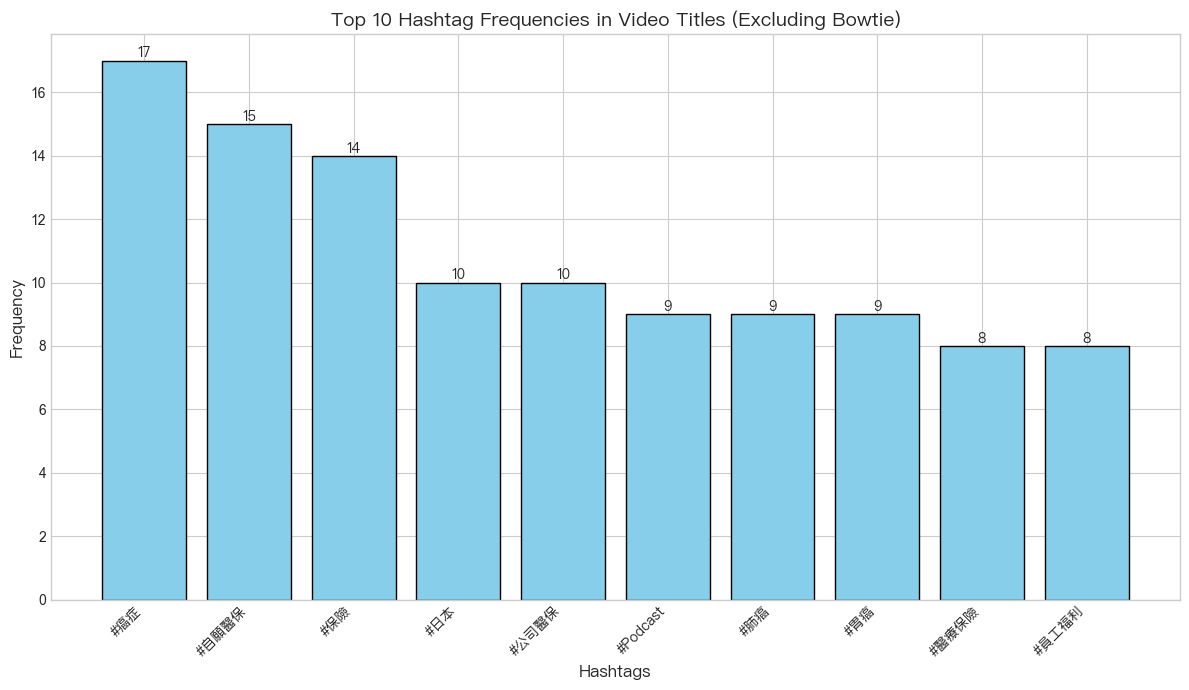

In [15]:
from matplotlib.font_manager import FontProperties
import re

# Your database connection setup (make sure engine is defined)
# from sqlalchemy import create_engine
# engine = create_engine('your_database_connection_string')

query = """
SELECT *
FROM videos v
WHERE v.channel_id = 'UCD5Lx-3KCYZzCzGF2A60STg'
ORDER BY v.published_at DESC;
"""

try:
    with engine.connect() as conn:
        result = conn.execute(text(query))
        df_monthly = pd.DataFrame(result.fetchall(), columns=result.keys())
    print(f"Success! Fetched {len(df_monthly)} videos.")
    print(df_monthly.head())  # Preview first 5 rows
    
    # Extract hashtags from titles
    def extract_hashtags(title):
        if pd.isna(title):
            return []
        return re.findall(r'#[^\s#]+', str(title))
    
    # Extract all hashtags across titles
    all_hashtags = [ht for title in df_monthly['title'] for ht in extract_hashtags(title)]
    
    # Counts (before filtering)
    total_occurrences = len(all_hashtags)
    unique_hashtags = set(all_hashtags)
    total_unique = len(unique_hashtags)
    titles_with_hashtags = sum(1 for title in df_monthly['title'] if extract_hashtags(title))
    
    print(f"\n--- Initial Hashtag Analysis (Before Filtering) ---")
    print(f"Total hashtag occurrences in titles: {total_occurrences}")
    print(f"Total unique hashtags: {total_unique}")
    print(f"Number of titles with at least one hashtag: {titles_with_hashtags}")
    
    # Filter out unwanted hashtags
    exclude_hashtags = {'#bowtie', '#Bowtie', '#bowtie保險', '#Bowtie保險'}
    
    def normalize_ht(ht):
        return ht.lower() if ht[1:].isascii() else ht
    
    filtered_hashtags = []
    for ht in all_hashtags:
        norm_ht = normalize_ht(ht)
        if norm_ht not in [normalize_ht(ex) for ex in exclude_hashtags]:
            filtered_hashtags.append(ht)
    
    # Recalculate after filtering
    if filtered_hashtags:
        hashtag_freq = pd.Series(filtered_hashtags).value_counts().head(10)
        print(f"\n--- Filtered Hashtag Analysis (Excluding #bowtie/#bowtie保險 variations) ---")
        print(f"Total hashtag occurrences (filtered): {len(filtered_hashtags)}")
        print(f"Top 10 most frequent hashtags:\n{hashtag_freq}")
        
        # Create figure and plot with proper font handling
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Try different font approaches
        try:
            # Try common Chinese fonts - macOS
            font_prop = FontProperties(fname='/System/Library/Fonts/PingFang.ttc')
            print("Using PingFang font (macOS)")
        except:
            try:
                # Try Windows Chinese fonts
                font_prop = FontProperties(fname='C:/Windows/Fonts/msyh.ttc')  # Microsoft YaHei
                print("Using Microsoft YaHei font (Windows)")
            except:
                try:
                    # Try another Windows font
                    font_prop = FontProperties(fname='C:/Windows/Fonts/simhei.ttf')  # SimHei
                    print("Using SimHei font (Windows)")
                except:
                    # Fallback to system default
                    font_prop = FontProperties()
                    print("Using system default font")
        
        # Create bar chart
        bars = ax.bar(range(len(hashtag_freq)), hashtag_freq.values, color='skyblue', edgecolor='black')
        ax.set_title('Top 10 Hashtag Frequencies in Video Titles (Excluding Bowtie)', fontproperties=font_prop, fontsize=14)
        ax.set_xlabel('Hashtags', fontproperties=font_prop, fontsize=12)
        ax.set_ylabel('Frequency', fontproperties=font_prop, fontsize=12)
        
        # Set x-tick labels with proper font
        ax.set_xticks(range(len(hashtag_freq)))
        ax.set_xticklabels(hashtag_freq.index, rotation=45, ha='right', fontproperties=font_prop)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                   str(int(height)), ha='center', va='bottom', fontproperties=font_prop)
        
        # Improve layout
        plt.tight_layout()
        
        # Display the plot
        plt.show()
        
        # Optional: Save the plot
        # plt.savefig('hashtag_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
        # print("Plot saved as 'hashtag_analysis.png'")
        
    else:
        print("No hashtags left after filtering!")
        
except SQLAlchemyError as e:
    print(f"SQL Error: {e}")
except KeyError as e:
    print(f"Error: Column not found - {e}. Available columns: {df_monthly.columns if 'df_monthly' in locals() else 'N/A'}")
except Exception as e:
    print(f"Unexpected error: {e}")

In [16]:
#!pip install vaderSentiment googletrans==4.0.0-rc1

import pandas as pd
import numpy as np
from sqlalchemy import text
from sqlalchemy.exc import SQLAlchemyError
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator  # For Chinese → English


Loaded 314 videos.
Translation error for '試當真 阿康 盜竊被捕｜偷竊癖 係咩回事？點解會控制唔到 衝動？｜偷嘢只因貪心？ DSE壓力 導致偷嘢？｜點樣幫到身邊有偷竊問題嘅人？｜心理學專家拆解真相｜#試當真 #阿康 #心理健康 #Bowtie': 'Translator' object has no attribute 'raise_Exception'
Translation error for '台灣地震 日本 地震 海嘯 警報！旅遊保 仲有冇用？｜咩保險包 地震？｜旅遊保 要幾時買？｜取消旅程 旅遊保險 可否索償？｜#日本 #台灣 #地震 #南海地震 #旅遊保 #Bowtie': 'Translator' object has no attribute 'raise_Exception'
Translation error for '日本 南海地震 新冠又爆發？邊個城市最危險？｜世衛建議未來每半年打 疫苗？｜KP.3 係咩嚟？新冠快測仲有用？｜旅行會唔會中招？｜醫務總監 拆解真相｜#日本 #COVID #新冠 #Bowtie': 'Translator' object has no attribute 'raise_Exception'
Translation error for '【運動受傷必睇】X光、MRI、CT、超聲波 邊個最啱你？': 'Translator' object has no attribute 'raise_Exception'
Translation error for '馬田 認證！醫院餐都有啖好食！｜新加坡喇沙+肉骨茶 港怡醫院名物｜鮑魚大過雞！鮑魚雞煲｜中大醫院 日式蒜香和牛粒+沙田凱悅酒店直送 煎春雞+沙田蘋果批｜#點CookGuide #馬田 #Bowtie': 'Translator' object has no attribute 'raise_Exception'
Translation error for '老高：咖啡降低死亡率？醫務總監JACKY不認同！｜咖啡與死亡率，無因果關係！｜咖啡防抑鬱、減雀斑、有助減肥？｜ 分析多項醫學報告查證老高說法問題之處！｜#健康 #咖啡 #4K #Bowtie': 'Translator' object has no attribute 'r

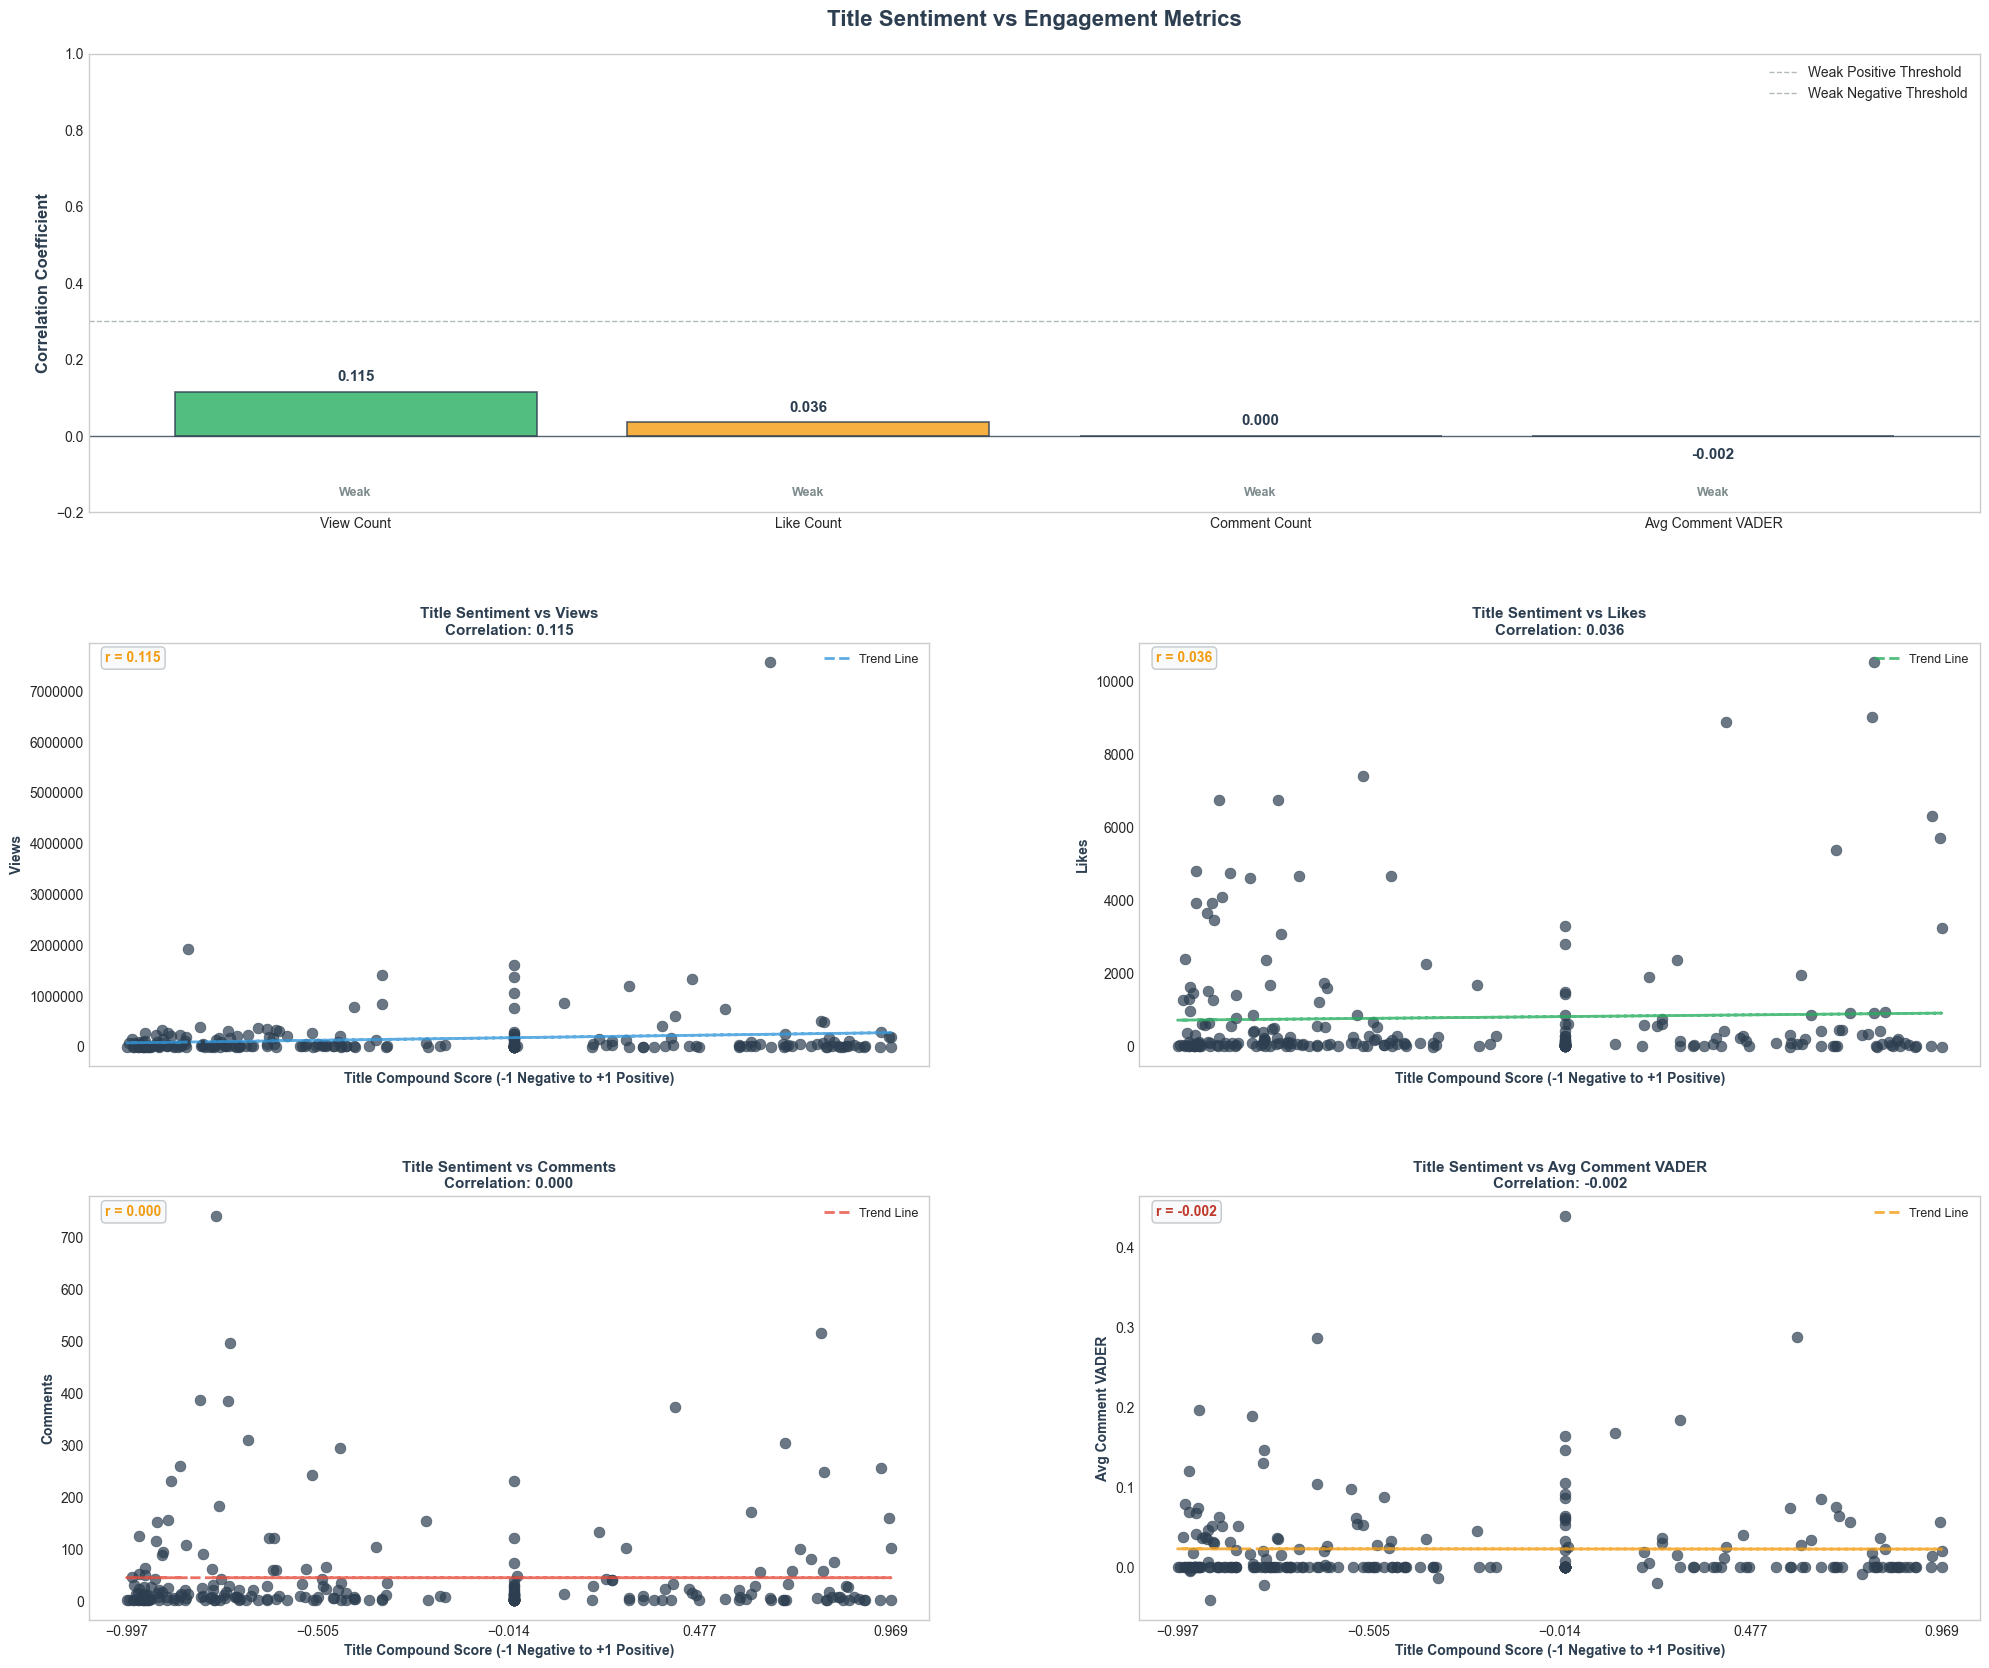


ENGAGEMENT CORRELATION SUMMARY:
• View: Weak positive correlation (r = 0.115)
• Like: Weak positive correlation (r = 0.036)
• Comment: Weak positive correlation (r = 0.000)
• Comment_Vader_Score VADER: Weak negative correlation (r = -0.002)

--- Quick Insights ---
• 134/239 videos (56.1%) have negative titles.
• Positive title sentiment mildly correlates with higher views.


In [18]:
# Init tools
analyzer = SentimentIntensityAnalyzer()
translator = Translator()

# Query: Videos + avg vader_score per video (2024-2025, Bowtie channel)
query = """
SELECT 
    v.video_id,
    v.title,
    v.view_count,
    v.like_count,
    v.comment_count,
    v.published_at,
    AVG(c.vader_score) AS avg_comment_vader_score
FROM videos v
LEFT JOIN comments c ON v.video_id = c.video_id
WHERE v.channel_id = 'UCD5Lx-3KCYZzCzGF2A60STg'
  AND v.published_at >= '2020-10-01'::date
  AND v.published_at <= '2025-10-31'::date
GROUP BY v.video_id, v.title, v.view_count, v.like_count, v.comment_count, v.published_at
ORDER BY v.published_at DESC;
"""

try:
    with engine.connect() as conn:
        result = conn.execute(text(query))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
    print(f"Loaded {len(df)} videos.")
    
    # Convert numerics (handle Decimal)
    numeric_cols = ['view_count', 'like_count', 'comment_count', 'avg_comment_vader_score']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Drop rows with NaN titles or metrics
    df = df.dropna(subset=['title'] + numeric_cols)
    
    if len(df) < 2:
        print("Insufficient data. Add more videos to DB.")
    else:
        # Function: Translate + Score (handles Chinese via Google Translate)
        def translate_and_score_chinese(title):
            if pd.isna(title):
                return {'compound': 0.0, 'sentiment': 'neutral', 'translated': ''}
            
            try:
                # Detect lang (auto) & translate if not English
                detected = translator.detect(str(title))
                if detected.lang != 'en':  # Assume Chinese if not English
                    translated = translator.translate(str(title), dest='en').text
                    #print(f"Translated: {title} → {translated}")  # Debug (uncomment if needed)
                else:
                    translated = str(title)
                
                # VADER on English
                scores = analyzer.polarity_scores(translated)
                compound = scores['compound']
                
                # Classify
                if compound > 0.05:
                    sentiment = 'positive'
                elif compound < -0.05:
                    sentiment = 'negative'
                else:
                    sentiment = 'neutral'
                
                return {'compound': compound, 'sentiment': sentiment, 'translated': translated}
            
            except Exception as e:
                print(f"Translation error for '{title}': {e}")
                return {'compound': 0.0, 'sentiment': 'neutral', 'translated': str(title)}
        
        # Apply to df
        df['title_analysis'] = df['title'].apply(translate_and_score_chinese)
        df['title_compound'] = df['title_analysis'].apply(lambda x: x['compound'])
        df['title_sentiment'] = df['title_analysis'].apply(lambda x: x['sentiment'])
        df['translated_title'] = df['title_analysis'].apply(lambda x: x['translated'])
        
        # Preview
        #print("\n--- Preview: Title Analysis ---")
        #print(df[['title', 'translated_title', 'title_compound', 'title_sentiment']].head())
        
        # Step 2: Group stats by sentiment
        grouped = df.groupby('title_sentiment')[numeric_cols].agg(['mean', 'std', 'count']).round(2)
        #print("\n--- Mean Metrics by Title Sentiment ---")
        #print(grouped)
        
        # Correlations: Title compound vs. each metric
        correlations = df[['title_compound'] + numeric_cols].corr()['title_compound'].drop('title_compound').round(3)
        #print(f"\n--- Correlations (Title Sentiment vs. Metrics) ---")
        #print(correlations)
        
        # Set style for plots
        sns.set_style("whitegrid")
        
        # Create combined figure with GridSpec: Bar on top (taller), 2x2 scatters below (equal heights)
        fig = plt.figure(figsize=(20, 18))  # Larger size to match second code
        gs = GridSpec(3, 2, figure=fig, height_ratios=[1.3, 1.2, 1.2])  # Uneven heights for bar emphasis
        
        # PART 1: CORRELATION ANALYSIS (Bar Plot on Top)
        ax_bar = fig.add_subplot(gs[0, :])  # Full width top row
        metrics_display = ['View Count', 'Like Count', 'Comment Count', 'Avg Comment VADER']
        corr_values = correlations.values
        colors = ['#E74C3C' if val < 0 else '#27AE60' if val > 0.1 else '#F39C12' for val in corr_values]  # Red, green, orange
        bars = ax_bar.bar(metrics_display, corr_values, color=colors, alpha=0.8, edgecolor='#2C3E50', linewidth=1.2)
        ax_bar.grid(False)  # Disable grid for bar plot
        
        # Professional title and label styling
        ax_bar.set_title('Title Sentiment vs Engagement Metrics', 
                         fontsize=16, fontweight='bold', pad=20, color='#2C3E50')
        ax_bar.set_ylabel('Correlation Coefficient', fontsize=12, fontweight='bold', color='#2C3E50')
        ax_bar.set_ylim(-0.2, 1.0)
        ax_bar.axhline(y=0, color='#2C3E50', linestyle='-', alpha=0.8, linewidth=1)
        ax_bar.axhline(y=0.3, color='#7F8C8D', linestyle='--', alpha=0.6, linewidth=1.0, label='Weak Positive Threshold')
        ax_bar.axhline(y=-0.3, color='#7F8C8D', linestyle='--', alpha=0.6, linewidth=1.0, label='Weak Negative Threshold')
        
        # Add value labels and significance indicators
        for bar, val in zip(bars, corr_values):
            height = bar.get_height()
            va = 'bottom' if height >= 0 else 'top'
            y_pos = height + 0.02 if height >= 0 else height - 0.03
            ax_bar.text(bar.get_x() + bar.get_width()/2, y_pos, f'{val:.3f}', 
                        ha='center', va=va, fontweight='bold', fontsize=11, color='#2C3E50')
            
            # Add significance marker
            if abs(val) > 0.5:
                significance = "Strong"
                color_sig = "#C0392B" if val < 0 else "#229954"
            elif abs(val) > 0.3:
                significance = "Moderate"
                color_sig = "#E67E22" if val < 0 else "#17A589"
            else:
                significance = "Weak"
                color_sig = "#7F8C8D"
            
            ax_bar.text(bar.get_x() + bar.get_width()/2, -0.15, significance, 
                        ha='center', va='center', fontweight='bold', color=color_sig, fontsize=9)
        
            # Professional insight annotation
            ax_bar.legend(loc='upper right', framealpha=0.9)
        
        # PART 2: SCATTER PLOTS WITH TREND LINES (2x2 Grid Below)
        # Configuration for each subplot - professional color scheme (colors for trendline, dots uniform)
        plot_configs = [
            ('view_count', 'Views', '#3498DB', correlations['view_count']),  # Blue
            ('like_count', 'Likes', '#27AE60', correlations['like_count']),  # Green
            ('comment_count', 'Comments', '#E74C3C', correlations['comment_count']),  # Red
            ('avg_comment_vader_score', 'Avg Comment VADER', '#F39C12', correlations['avg_comment_vader_score'])  # Orange
        ]
        
        # Create subplots for scatters
        axes = [
            fig.add_subplot(gs[1, 0]),
            fig.add_subplot(gs[1, 1]),
            fig.add_subplot(gs[2, 0]),
            fig.add_subplot(gs[2, 1])
        ]
        
        # Plot each scatter with trendline
        for idx, (metric_col, metric_name, color, corr) in enumerate(plot_configs):
            ax = axes[idx]
            ax.grid(False)  # Disable grid for scatter plots
            
            # Scatter points - all dots uniform color '#2C3E50'
            scatter = ax.scatter(df['title_compound'], df[metric_col], 
                                 alpha=0.7, color='#2C3E50', s=60, edgecolor='#2C3E50', linewidth=0.5)
            
            # Add trendline (linear fit) - using subplot color for variety
            z = np.polyfit(df['title_compound'], df[metric_col], 1)
            p = np.poly1d(z)
            ax.plot(df['title_compound'], p(df['title_compound']), color=color, 
                    linestyle='--', linewidth=2, alpha=0.8, label='Trend Line')
            
            # Professional subplot styling
            ax.set_title(f'Title Sentiment vs {metric_name}\nCorrelation: {corr:.3f}', 
                         fontweight='bold', fontsize=11, color='#2C3E50')
            ax.set_xlabel('Title Compound Score (-1 Negative to +1 Positive)', fontsize=10, fontweight='bold', color='#2C3E50')
            ax.set_ylabel(metric_name, fontsize=10, fontweight='bold', color='#2C3E50')
            if metric_col == 'view_count':
                ax.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation
            ax.legend(fontsize=9, loc='upper right', framealpha=0.9)
            
            # X-axis formatting (labels only on bottom row)
            if idx >= 2:
                ax.set_xticks(np.linspace(df['title_compound'].min(), df['title_compound'].max(), 5))
                ax.set_xlabel('Title Compound Score (-1 Negative to +1 Positive)', fontsize=10, fontweight='bold', color='#2C3E50')
            else:
                ax.set_xticks([])
                ax.tick_params(axis='x', which='both', bottom=False, top=False)
            
            # Professional correlation indicator
            correlation_color = '#C0392B' if corr < 0 else '#27AE60' if corr > 0.3 else '#F39C12'
            ax.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax.transAxes,
                    fontsize=10, fontweight='bold', va='top', color=correlation_color,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="#F8F9FA", alpha=0.9, edgecolor='#BDC3C7'))
        
        # Final professional touches
        #fig.suptitle('Title Sentiment vs Engagement Metrics (Bowtie Channel, 2024-2025)', fontsize=18, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.25, bottom=0.08)
        plt.savefig('visualization/Title Sentiment vs Engagement Metrics.png', dpi=300, bbox_inches='tight') 
        plt.show()
        
        # ADDITIONAL INSIGHTS SUMMARY
        print("\nENGAGEMENT CORRELATION SUMMARY:")
        for metric, corr in correlations.items():
            metric_name = metric.replace('_count', '').replace('avg_', '').title() + ' VADER' if 'vader' in metric else metric.replace('_count', '').replace('avg_', '').title()
            strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
            direction = "negative" if corr < 0 else "positive"
            print(f"• {metric_name}: {strength} {direction} correlation (r = {corr:.3f})")
        
        # Insights
        neg_pct = (df['title_sentiment'] == 'negative').mean() * 100
        print(f"\n--- Quick Insights ---")
        print(f"• {len(df[df['title_sentiment'] == 'negative'])}/{len(df)} videos ({neg_pct:.1f}%) have negative titles.")
        if correlations['view_count'] > 0.1:
            print("• Positive title sentiment mildly correlates with higher views.")
        elif correlations['comment_count'] > 0.2:
            print("• Negative titles may boost comments (debate driver).")
        else:
            print("• No strong links—negative titles don't consistently outperform.")

except SQLAlchemyError as e:
    print(f"SQL Error: {e}")
except Exception as e:
    print(f"Error: {e} (Ensure vaderSentiment and googletrans are installed: pip install vaderSentiment googletrans==4.0.0-rc1)")